In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("MUMBAI.csv")

/var/folders/kt/q0sjjgn94nz3_lf77pxkgr6h0000gn/T/ipykernel_1276/3117104334.py:3: DtypeWarning: Columns (12,18,19,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("MUMBAI.csv")


  INDEX : Index No. of the station

  MN    : Month

  HR    : Hour Code

  DT    : Date
  SLP   : Station Level Pressure hpa
  MSLP  : Mean Sea Level Pressure hpa

  DBT   : Dry bulb Temperature oC

  WBT   : Wet bulb Temperature oC

  DPT   : Dew point Temperature oC

  RH    : Relative Humidity in %, i.e. 090 means 90 %.

  VP    : Vapour Pressure in hpa

  DD    : Wind Direction in 16 points of compass

  FFF   : Wind Speed in Km. per hour

  AW    : Average Wind speed

  VV    : Visibility

  Cl    : Form of Low cloud

  A     : Amount of Low cloud

  Cm    : Form of Medium cloud

  A.1   : Amount of Medium cloud

  Ch    : Form of High Cloud

  A.2   : Amount of High cloud

  Dl    : Direction of low cloud in 8 points of compass (in code)

  Dm    : Direction of medium cloud in 8 points of compass (in code)

  Dh    : Direction of high cloud in 8 points of compass (in code)

  TC    : Total amount of cloud (in oktas)

  h     : Height of low cloud

  c     : Form of individual Layer of cloud

  a     : Amount of individual Layer of cloud

  Ht    : Height of individual Layer of cloud (in code)

  RF    : Total Rainfall since previous observation in mm

  EVP   : Total Evaporation in mm

  DW    : Direction of Wave in 16 points of compass (in code)

  P     : Period of wave (in code)

  H     : Height of wave (in code)

  WAT   : Water Temperature in degree C

In [2]:
df=df.iloc[:,:-2]
df=df.apply(pd.to_numeric,errors='coerce')

# As avg wind speed is missing for 21126 columns
df[['AW','FFF']].corr()
# So correlation is moderate and 75% of AW data is missing let's drop it.
df.drop(["AW"], axis=1,inplace=True)

df["HR"]=df["HR"]/4

# List of categorical columns to fill by month-wise mode
cat_cols_by_month = ['DD', 'Cm', 'A.1', 'Dl', 'Dm', 'TC', 'h', 'c', 'Ht']

# Filling each categorical column's null values using the mode of its month
for col in cat_cols_by_month:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill high-null categorical columns with month-wise mode or 'Unknown'
for col in ['Ch', 'A.2', 'Dh']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill numeric columns with median of the respective month
for col in ['VP', 'FFF', 'VV']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.median()))

# Fill 'DD' with mode of respective month
df['DD'] = df.groupby('MN')['DD'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill missing values with month-wise median
df['RF'] = df.groupby('MN')['RF'].transform(lambda x: x.fillna(x.median()))
# Fill by daily median first , Beacuse it may vary day to day a lot.
df['EVP'] = df.groupby(['YEAR', 'MN', 'DT'])['EVP'].transform(lambda x: x.fillna(x.median()))

# Removing INDEX and setime datetime as new Index
df=df.drop('INDEX',axis=1)
df['datetime']=pd.to_datetime(df[['YEAR','MN','DT','HR']].rename(columns={
    'YEAR':'year',
    'MN':'month',
    'DT':'day',
    'HR':'hour'
}),errors='coerce')

df.index = pd.to_datetime(df.index)
df = df[df['datetime'].dt.year != 2020]
df.set_index('datetime',inplace=True)

In [3]:
# As month,day and time don't affect fff much so drop them
df.drop(['YEAR','MN','DT','HR'],axis=1,inplace=True)

# Sorting the dataframe by timestamp
df = df.sort_values('datetime')

In [4]:
# Outlier Detection
from scipy.stats import zscore
import numpy as np

# Step 1: Select numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Compute Z-scores for each numeric column
z_scores = np.abs(zscore(df[numeric_cols]))

# Step 3: Define a threshold and filter out outliers
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]

FFF     1.000000
DD      0.805569
DBT     0.503113
WBT     0.371896
A       0.288358
Cl      0.278726
TC      0.277204
Dl      0.254787
c       0.251594
Ht      0.251594
VP      0.236208
VV      0.221812
DPT     0.216186
RF      0.208417
Dm      0.188280
Cm      0.178491
A.1     0.149542
A.2     0.001219
Ch     -0.001513
Dh     -0.004911
RH     -0.233898
EVP    -0.237352
h      -0.265520
a      -0.266727
SLP    -0.364263
MSLP   -0.366972
Name: FFF, dtype: float64


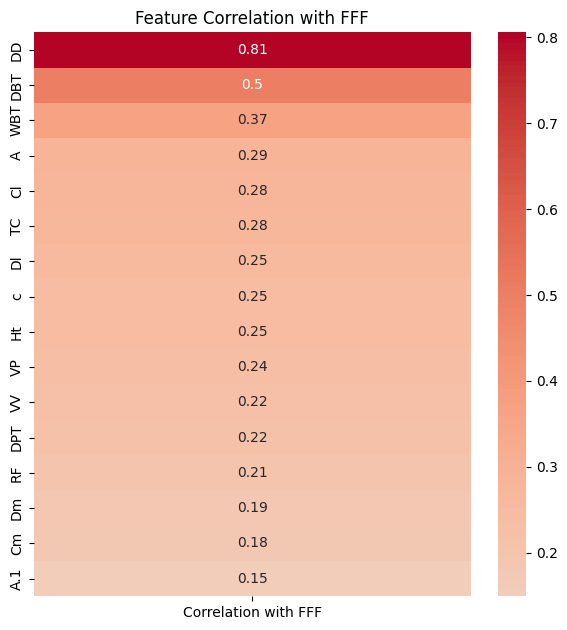

In [5]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)

features = [
     'DD', 'DBT', 'WBT', 'A', 'Cl', 'TC', 'Dl', 'c', 'Ht',
     'VP', 'VV','DPT',  'RF', 'Dm', 'Cm', 'A.1'
]

import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of each feature with FFF
correlation_with_fff = df[features + ['FFF']].corr()['FFF'].drop('FFF')

# Convert to DataFrame for heatmap
corr_df = correlation_with_fff.to_frame(name='Correlation with FFF')

# Plot heatmap
plt.figure(figsize=(6, len(corr_df) * 0.4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with FFF')
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
df['VP_log'] = np.log1p(df['VP'])
df['RF_sqrt'] = np.sqrt(df['RF'])       # for skewed rainfall

df['temp_diff'] = df['DBT'] - df['WBT']     # humidity proxy
df['humid_ratio'] = df['VP'] / (df['DBT'] + 0.1)
df['wind_humidity'] = df['RH'] * df['VV']

df['VV_squared'] = df['VV'] ** 2
df['DPT_squared'] = df['DPT'] ** 2

df['VP_roll3'] = df['VP'].rolling(window=3).mean()
df['RF_lag1'] = df['RF'].shift(1)

from scipy.stats.mstats import winsorize

df['RF_winz'] = winsorize(df['RF'], limits=[0.01, 0.01])

df['month'] = df.index.month
df['season'] = df['month'] % 12 // 3 + 1  # Season: 1=spring, ..., 4=winter

# Cyclic encode ==>> As months are in a cycle 1->12->1
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# (Optional) Drop original month column
df.drop('month', axis=1, inplace=True)

# One hot encoding ==>> COnverting categorical into Binary data
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)
df.drop('season', axis=1, inplace=True)

# Convert boolean columns to int (0 or 1) after one-hot encoding
for col in season_dummies.columns:
    df[col] = df[col].astype(int)


df.dropna(axis=0,inplace=True)
df.isnull().sum()
df.dtypes

SLP              float64
MSLP             float64
DBT              float64
WBT              float64
DPT              float64
RH                 int64
VP               float64
DD               float64
FFF              float64
VV               float64
Cl                 int64
A                  int64
Cm               float64
A.1              float64
Ch               float64
A.2              float64
Dl               float64
Dm               float64
Dh               float64
TC               float64
h                float64
c                float64
a                  int64
Ht               float64
RF               float64
EVP              float64
VP_log           float64
RF_sqrt          float64
temp_diff        float64
humid_ratio      float64
wind_humidity    float64
VV_squared       float64
DPT_squared      float64
VP_roll3         float64
RF_lag1          float64
RF_winz          float64
month_sin        float64
month_cos        float64
season_1           int64
season_2           int64


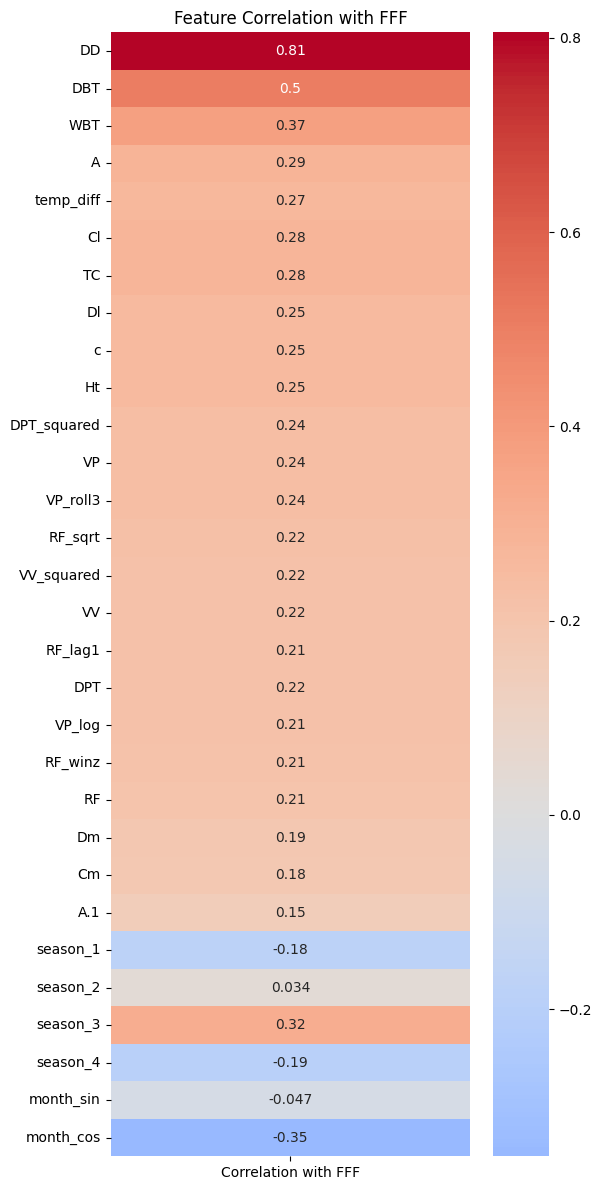

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt

features = [
     'DD', 'DBT', 'WBT', 'A', 'temp_diff', 'Cl', 'TC', 'Dl', 'c', 'Ht',
    'DPT_squared', 'VP', 'VP_roll3', 'RF_sqrt', 'VV_squared', 'VV',
    'RF_lag1', 'DPT', 'VP_log', 'RF_winz', 'RF', 'Dm', 'Cm', 'A.1','season_1','season_2','season_3','season_4','month_sin','month_cos'
]

# Compute correlation of each feature with FFF
correlation_with_fff = df[features + ['FFF']].corr()['FFF'].drop('FFF')

# Convert to DataFrame for heatmap
corr_df = correlation_with_fff.to_frame(name='Correlation with FFF')

# Plot heatmap
plt.figure(figsize=(6, len(corr_df) * 0.4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with FFF')
plt.tight_layout()
plt.show()


In [8]:
# Feature columns (you can fine-tune this list)
features = [
     'DD', 'DBT', 'WBT', 'A', 'temp_diff', 'Cl', 'TC', 'Dl', 'c', 'Ht',
    'DPT_squared', 'VP', 'VP_roll3', 'RF_sqrt', 'VV_squared', 'VV',
    'RF_lag1', 'DPT', 'VP_log', 'RF_winz', 'RF', 'Dm', 'Cm', 'A.1','season_1','season_2','season_3','season_4','month_sin','month_cos'
]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# X = your features, y = your target (e.g. FFF)
X = df[features]  # your selected columns
Y = df['FFF']

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

DD             0.772277
VP_roll3       0.045990
temp_diff      0.026797
DBT            0.025460
WBT            0.013895
season_3       0.012982
VP_log         0.008638
VP             0.008501
RF_lag1        0.008400
month_cos      0.008382
DPT_squared    0.008250
TC             0.008248
DPT            0.007986
month_sin      0.007818
A              0.005571
Cl             0.004424
A.1            0.004071
season_2       0.003314
VV             0.002629
VV_squared     0.002608
RF             0.002600
RF_sqrt        0.002541
RF_winz        0.002368
Cm             0.002046
Ht             0.001233
c              0.001162
Dm             0.000799
season_4       0.000470
season_1       0.000295
Dl             0.000242
dtype: float64


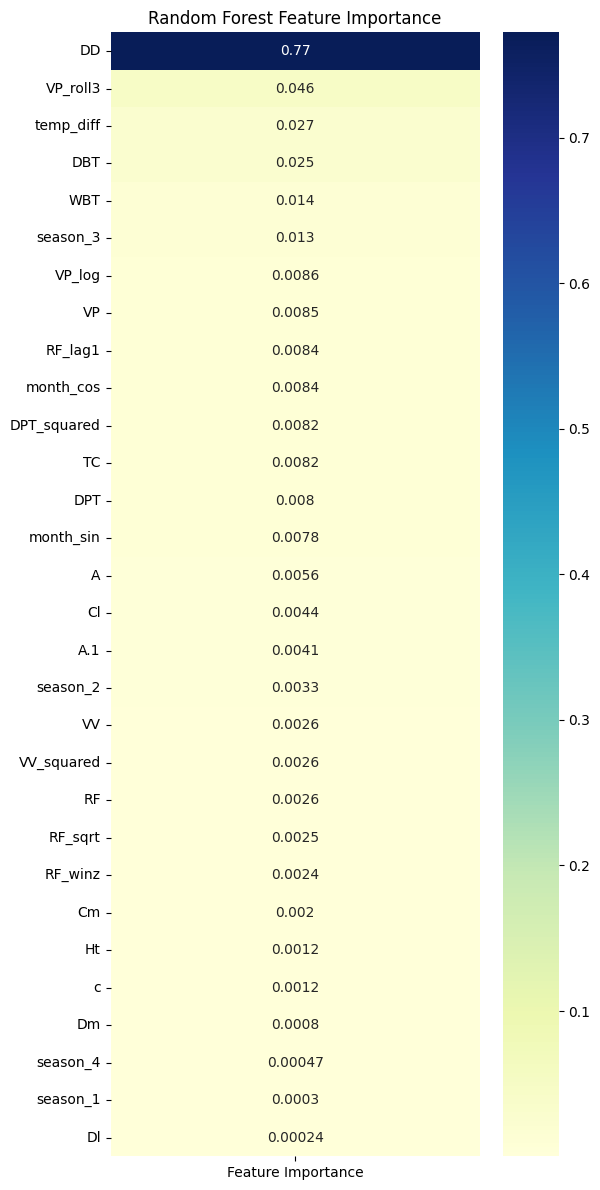

In [9]:
# Convert to DataFrame for heatmap
importance_df = importances.to_frame(name='Feature Importance')

# Plot heatmap
plt.figure(figsize=(6, len(importance_df) * 0.4))
sns.heatmap(importance_df, annot=True, cmap='YlGnBu')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [10]:
# WE WILL KEEP FEATURES of importance ≥ 0.005 AND |correlation| ≥ 0.15
# SO NOW WILL SPLIT FEATURES INTO 2 GROUPS
primary_features=['DD', 'DBT', 'WBT', 'DPT', 'DPT_squared', 'VP_log', 'VP_roll3', 'RF_lag1',
 'VP', 'temp_diff', 'TC', 'A', 'Cl','season_3','month_sin','month_cos']
# Will try with these also and check is model performing more better or not.
secondary_features=['Dl','Ht', 'c', 'VV', 'Dm', 'Cm','season_2']

In [11]:
# Using BiLSTM
# Reshape input for BiLSTM
import numpy as np
from sklearn.model_selection import train_test_split

# Identify non-numeric columns in df[primary_features]
non_numeric_cols = df[primary_features].select_dtypes(exclude=np.number).columns

# Convert non-numeric columns to numeric, coercing errors
for col in non_numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# X = your selected primary features
# Y = target variable (FFF)

X = df[primary_features].values
Y = df['FFF'].values

def create_lookback_sequences(X, Y, lookback):
    Xs, Ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        Ys.append(Y[i])
    return np.array(Xs), np.array(Ys)

lookback = 24  # will come from GWO population

X_combined, Y_combined = create_lookback_sequences(X, Y, lookback)

# Split after generating sequences
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y_combined, test_size=0.2, random_state=42)
input_shape = (X_train.shape[1], X_train.shape[2])

In [12]:
# Using PSO

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_bilstm_model(input_shape, units=64, dropout_rate=0.2, num_layers=1, learning_rate=0.001):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    for i in range(num_layers):
        return_seq = i < num_layers - 1
        model.add(Bidirectional(LSTM(units, return_sequences=return_seq), input_shape=input_shape if i == 0 else None))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

def gwo_objective(params):
    from sklearn.metrics import mean_squared_error
    params = np.asarray(params, dtype=np.float64)
    units = int(round(params[0]))
    dropout = float(params[1])
    batch_size = int(round(params[2]))
    lookback = int(round(params[3]))
    num_layers = int(round(params[4]))
    learning_rate = float(params[5])

    # Ensure lookback is at least 1
    lookback = max(1, lookback)

    X_combined, Y_combined = create_lookback_sequences(X, Y, lookback)

    # Check if sequences are empty
    if len(X_combined) == 0:
        print(f"Warning: No sequences created with lookback={lookback}. Returning a high MSE.")
        return float('inf')

    X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y_combined, test_size=0.2, random_state=42)

    # Explicitly cast data to float32
    X_train = X_train.astype(np.float32)
    Y_train = Y_train.astype(np.float32)


    # Model
    model = create_bilstm_model(
        input_shape=(lookback, X.shape[1]),
        units=units,
        dropout_rate=dropout,
        num_layers=num_layers,
        learning_rate=learning_rate
    )
    model.fit(X_train, Y_train, epochs=10, batch_size=batch_size, verbose=0, validation_split=0.1)
    preds = model.predict(X_test)
    mse = mean_squared_error(Y_test, preds)
    return mse

In [13]:
# Define lower and upper bounds for each hyperparameter
# Format: [units, dropout, batch_size, lookback, num_layers, learning_rate]
lb = [32, 0.1, 16, 3, 1, 0.0001]
ub = [128, 0.5, 128, 24, 3, 0.01]

dim = len(lb) # number of hyperparameters

import numpy as np

# Initialize population of wolves
search_agents = 5  # Number of wolves (solutions)
population = np.random.uniform(low=lb, high=ub, size=(search_agents, dim))
population = np.array(population, dtype=np.float64)

# Initialize alpha, beta, and delta wolves (best three solutions so far)
alpha_pos = np.zeros(dim)
alpha_score = float("inf")

beta_pos = np.zeros(dim)
beta_score = float("inf")

delta_pos = np.zeros(dim)
delta_score = float("inf")

epochs = 5  # Number of iterations of optimization

# Loop through each epoch
fitness_per_epoch = []
for epoch in range(epochs):
    for i in range(search_agents):
        # Clip to stay within bounds
        population[i] = np.clip(population[i], lb, ub).astype(np.float64)
        # Evaluate fitness (MAE) of the current wolf
        population[i] = population[i].astype(np.float64)
        fitness = gwo_objective(population[i].astype(np.float64))

        # Update alpha, beta, delta wolves
        if fitness < alpha_score:
            alpha_score = fitness
            alpha_pos = population[i].copy()
        elif fitness < beta_score:
            beta_score = fitness
            beta_pos = population[i].copy()
        elif fitness < delta_score:
            delta_score = fitness
            delta_pos = population[i].copy()

    fitness_per_epoch.append(alpha_score)

    # Linearly decreased from 2 to 0
    a = 2 - epoch * (2 / epochs)

    # Update position of each wolf
    for i in range(search_agents):
        for j in range(dim):
            r1, r2 = np.random.rand(), np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_alpha = abs(C1 * alpha_pos[j] - population[i][j])
            X1 = alpha_pos[j] - A1 * D_alpha

            r1, r2 = np.random.rand(), np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_beta = abs(C2 * beta_pos[j] - population[i][j])
            X2 = beta_pos[j] - A2 * D_beta

            r1, r2 = np.random.rand(), np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_delta = abs(C3 * delta_pos[j] - population[i][j])
            X3 = delta_pos[j] - A3 * D_delta

            # Update current position
            population[i][j] = float((X1 + X2 + X3) / 3)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [14]:
# Output best solution
print("\nBest Hyperparameters Found:")
print(f"Units         : {int(alpha_pos[0])}")
print(f"Dropout       : {float(alpha_pos[1])}")
print(f"Batch Size    : {int(alpha_pos[2])}")
print(f"Lookback      : {float(alpha_pos[3])}")
print(f"Num Layers    : {int(alpha_pos[4])}")
print(f"Learning rate : {float(alpha_pos[5])}")


unit_sizee = int(alpha_pos[0])
dropoutt = float(alpha_pos[1])
batch_sizee = int(alpha_pos[2])
lookbackk = int(alpha_pos[3])
num_layers = int(alpha_pos[4])
learning_ratee = float(alpha_pos[5])


Best Hyperparameters Found:
Units         : 111
Dropout       : 0.12604459312699667
Batch Size    : 36
Lookback      : 16.649132310152158
Num Layers    : 2
Learning rate : 0.0014088769185146104


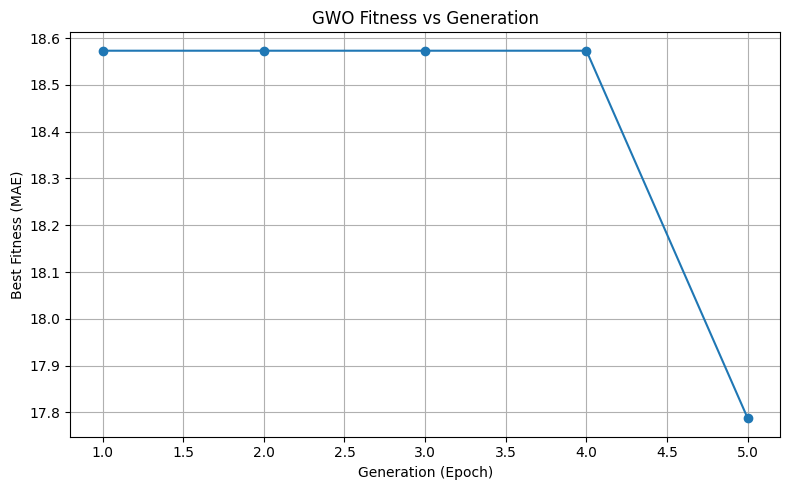

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), fitness_per_epoch, marker='o', linestyle='-')
plt.xlabel('Generation (Epoch)')
plt.ylabel('Best Fitness (MAE)')
plt.title('GWO Fitness vs Generation')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# BiLSTM CONTINUES
X_seq, Y_seq = create_lookback_sequences(X, Y, lookbackk) # Use lookbackk from GWO results
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)

# Explicitly cast data to float32
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.float32)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Build the model
model = Sequential()
for i in range(num_layers):
    return_seq = i < num_layers - 1
    if i == 0:
        model.add(Bidirectional(LSTM(unit_sizee, return_sequences=return_seq), input_shape=(lookbackk, X.shape[1])))
    else:
        model.add(Bidirectional(LSTM(unit_sizee, return_sequences=return_seq)))
    model.add(Dropout(dropoutt))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_ratee), loss='mean_squared_error', metrics=['mae'])

# Train model
model.fit(X_train, Y_train, epochs=50, batch_size=batch_sizee, validation_split=0.1, verbose=1)

# Make predictions
Y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 28.4088 - mae: 4.4193 - val_loss: 22.1044 - val_mae: 3.7105
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 21.9644 - mae: 3.7241 - val_loss: 22.3334 - val_mae: 3.8423
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 20.9114 - mae: 3.6265 - val_loss: 21.3344 - val_mae: 3.7173
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 20.1760 - mae: 3.5598 - val_loss: 20.5617 - val_mae: 3.5714
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 19.3684 - mae: 3.4396 - val_loss: 19.5776 - val_mae: 3.4429
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 20.0136 - mae: 3.5096 - val_loss: 19.5926 - val_mae: 3.4070
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 19.9838 - mae: 3.5122 - val_loss: 20.5035 - val_mae: 3.4633
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 19.5751 - mae: 3.4624 - val_loss: 19.6558 - val_mae: 3.4592
Epoch 9/50
451/451 ━━━━━━━━━━━━━━━━

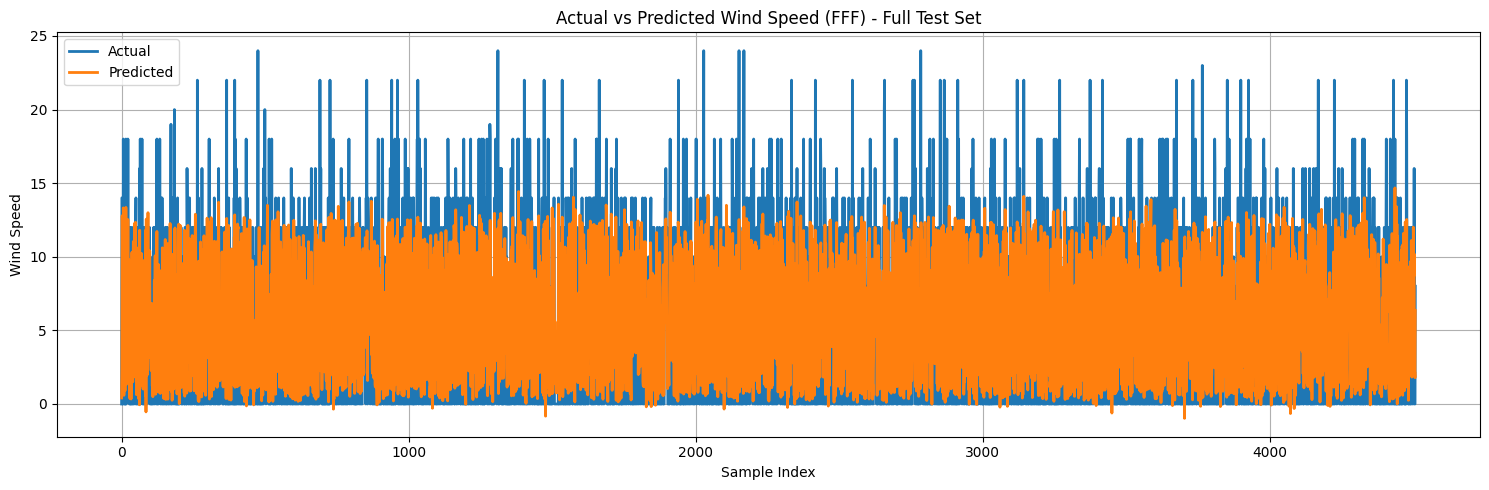

In [17]:
# Plot predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(Y_test, label='Actual', linewidth=2)
plt.plot(Y_pred.flatten(), label='Predicted', linewidth=2) # Flatten Y_pred for plotting
plt.title("Actual vs Predicted Wind Speed (FFF) - Full Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

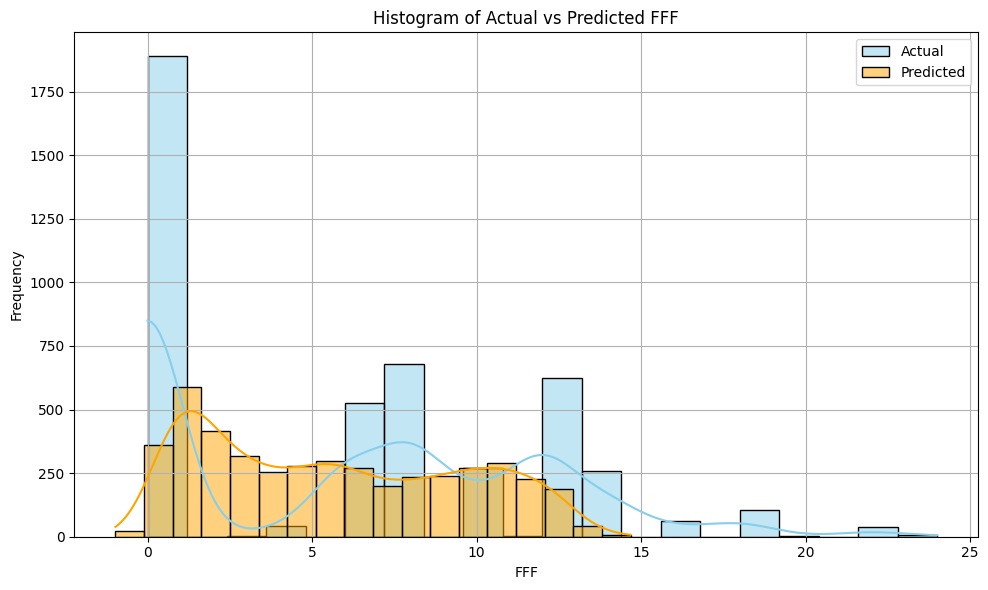

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Flatten arrays for plotting
y_true_flat = Y_test.flatten()
y_pred_flat = Y_pred.flatten()

# Create a DataFrame for easier plotting
df_hist = pd.DataFrame({
    'Actual': y_true_flat,
    'Predicted': y_pred_flat
})

plt.figure(figsize=(10, 6))
sns.histplot(df_hist['Actual'], color="skyblue", label="Actual", kde=True)
sns.histplot(df_hist['Predicted'], color="orange", label="Predicted", kde=True)
plt.title("Histogram of Actual vs Predicted FFF")
plt.xlabel("FFF")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

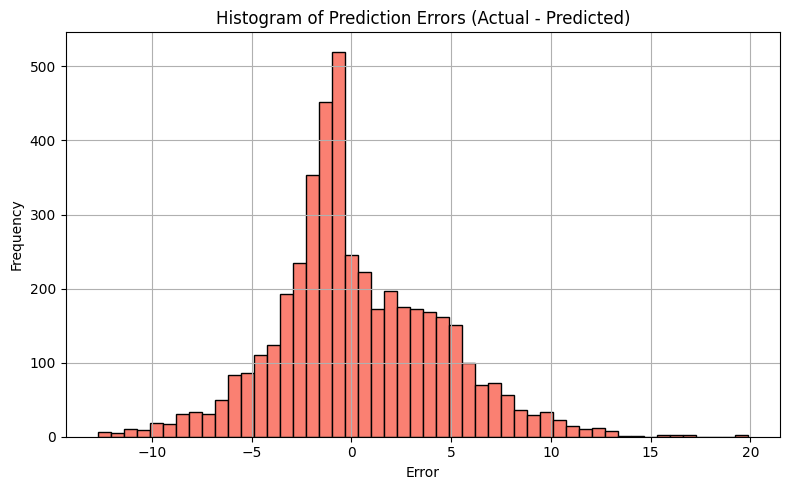

In [19]:
# Histogram Prediction error
error = y_true_flat - y_pred_flat

plt.figure(figsize=(8, 5))
plt.hist(error, bins=50, color='salmon', edgecolor='black')
plt.title("Histogram of Prediction Errors (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Directory for saving plots and CSV
output_dir = "plot"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

import pandas as pd

# Replace with actual best values from your GWO
result = {
    "Timestamp": timestamp,
    "Units": unit_sizee,
    "Dropout": dropoutt,
    "Batch Size":batch_sizee,
    "Learning Rate":learning_ratee,
    "Num Layers":num_layers,
    "Lookback":lookbackk,
    "MAE": mae,
    "MSE": mse,
    "R2":r2
}

csv_path = os.path.join(output_dir, "BI_GWO.csv")

# Append to CSV
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    df_existing = pd.concat([df_existing, pd.DataFrame([result])], ignore_index=True)
    df_existing.to_csv(csv_path, index=False)
else:
    pd.DataFrame([result]).to_csv(csv_path, index=False)

print(f"Results appended to CSV: {csv_path}")

Results appended to CSV: plot/BI_GWO.csv
